In [1]:
import numpy as np
from stl import mesh

from slepian_python import *

## Description

Graph slepians on the panther mesh 

GOAL: Compute bandlimited and vertex specific optimal signal

## Table of Contents
- [Load Mesh](#SR)
- [Graph Slepians Application](#nyquist)
    - Test 1: Bandlimit NW=9
    - Test 2: Bandlimit NW=1000

In [137]:
def z_score(arr):
    tmp = arr - arr.min()
    z = tmp / tmp.max()
    return z

def normalize(tmp):
    m, s = tmp.mean(), tmp.std()
    tmp = tmp - m
    norm = tmp/s

    return norm

## Load Mesh

In [2]:
# load mesh
bear_mesh = mesh.Mesh.from_file('./data/oncapintada.stl')

# f1: point1 in faces | f2: point2 in faces ...
f1 = bear_mesh.vectors[:,0,:]
f2 = bear_mesh.vectors[:,1,:]
f3 = bear_mesh.vectors[:,2,:]
nb_faces = f1.shape[0]

In [3]:
# associate index to each 3d point
coord2idx = {}
c = 0
f = np.concatenate([f1,f2,f3])
for k in range(nb_faces * 3):
    tmp = tuple(f[k])
    if tmp not in coord2idx:
        coord2idx[tmp] = c
        c += 1

vertices = np.array(list(coord2idx.keys()))
nb_nodes = np.array(list(coord2idx.values())).max() + 1

# bool array as flags
head_indexes = (vertices[:,1] < -0.4)

In [49]:
# Adjacency matrix
Adj = np.empty((nb_nodes,nb_nodes))
faces_index = []
head_coloring = []
for k in range(nb_faces):
    # convert to index the coordinate
    idx1 = coord2idx[tuple(f1[k])]
    idx2 = coord2idx[tuple(f2[k])]
    idx3 = coord2idx[tuple(f3[k])]

    faces_index.append([idx1,idx2,idx3])
    c = int(head_indexes[idx1] + head_indexes[idx2] + head_indexes[idx3])
    head_coloring.append(c)
    # populate the adjacency matrix with the edges from the face
    Adj[idx1,idx2] = 1
    Adj[idx1,idx3] = 1
    Adj[idx2,idx1] = 1
    Adj[idx2,idx3] = 1
    Adj[idx3,idx1] = 1
    Adj[idx3,idx2] = 1

### Display Nodes Selection

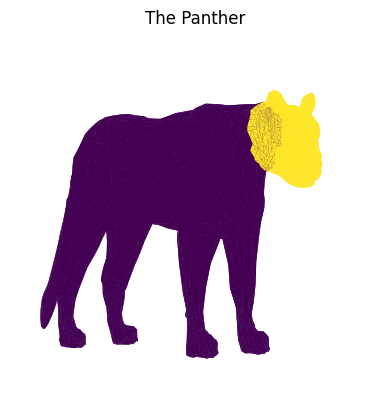

In [161]:
faces_index = np.asarray(faces_index)
head_coloring = np.asarray(head_coloring)
plot_mesh(vertices, faces_index, head_coloring)

## Graph Slepians Application

### Bandlimit NW=9

#### Compute Slepian Vectors and Evaluations

In [27]:
# Compute laplacian
Deg = np.sum(Adj,axis=1)
Lap = laplacian(Deg,Adj)
norm_L = normalize_adjmat(Lap, Deg)

In [215]:
NW = 9
basis, basis_eig0, basis_conc, basis_cut = compute_slepians(norm_L, head_indexes, NW, 1, maxiter=2500)

#### Paper: Figure 2

In [231]:
# subplot 1
head_color = np.zeros_like(head_indexes, dtype=float)
head_color[head_indexes] = 1.0

# subplot 2
orig = basis[0][:,1]
secondsig = np.sin(normalize(orig) * 2*np.pi * 2)

# Filtering results
filter1 = np.exp(-40 * basis_eig0[0])
filter2 = np.exp(-40 * basis_cut[2])
# subplot 3
sig_filter1 = (basis[0] @ np.diag(filter1) @ (basis[0].T @ secondsig))
sig_filter2 = (basis[2] @ np.diag(filter2) @ (basis[2].T @ secondsig))

toplots = np.stack([head_color, secondsig, sig_filter1, sig_filter2], axis=1)

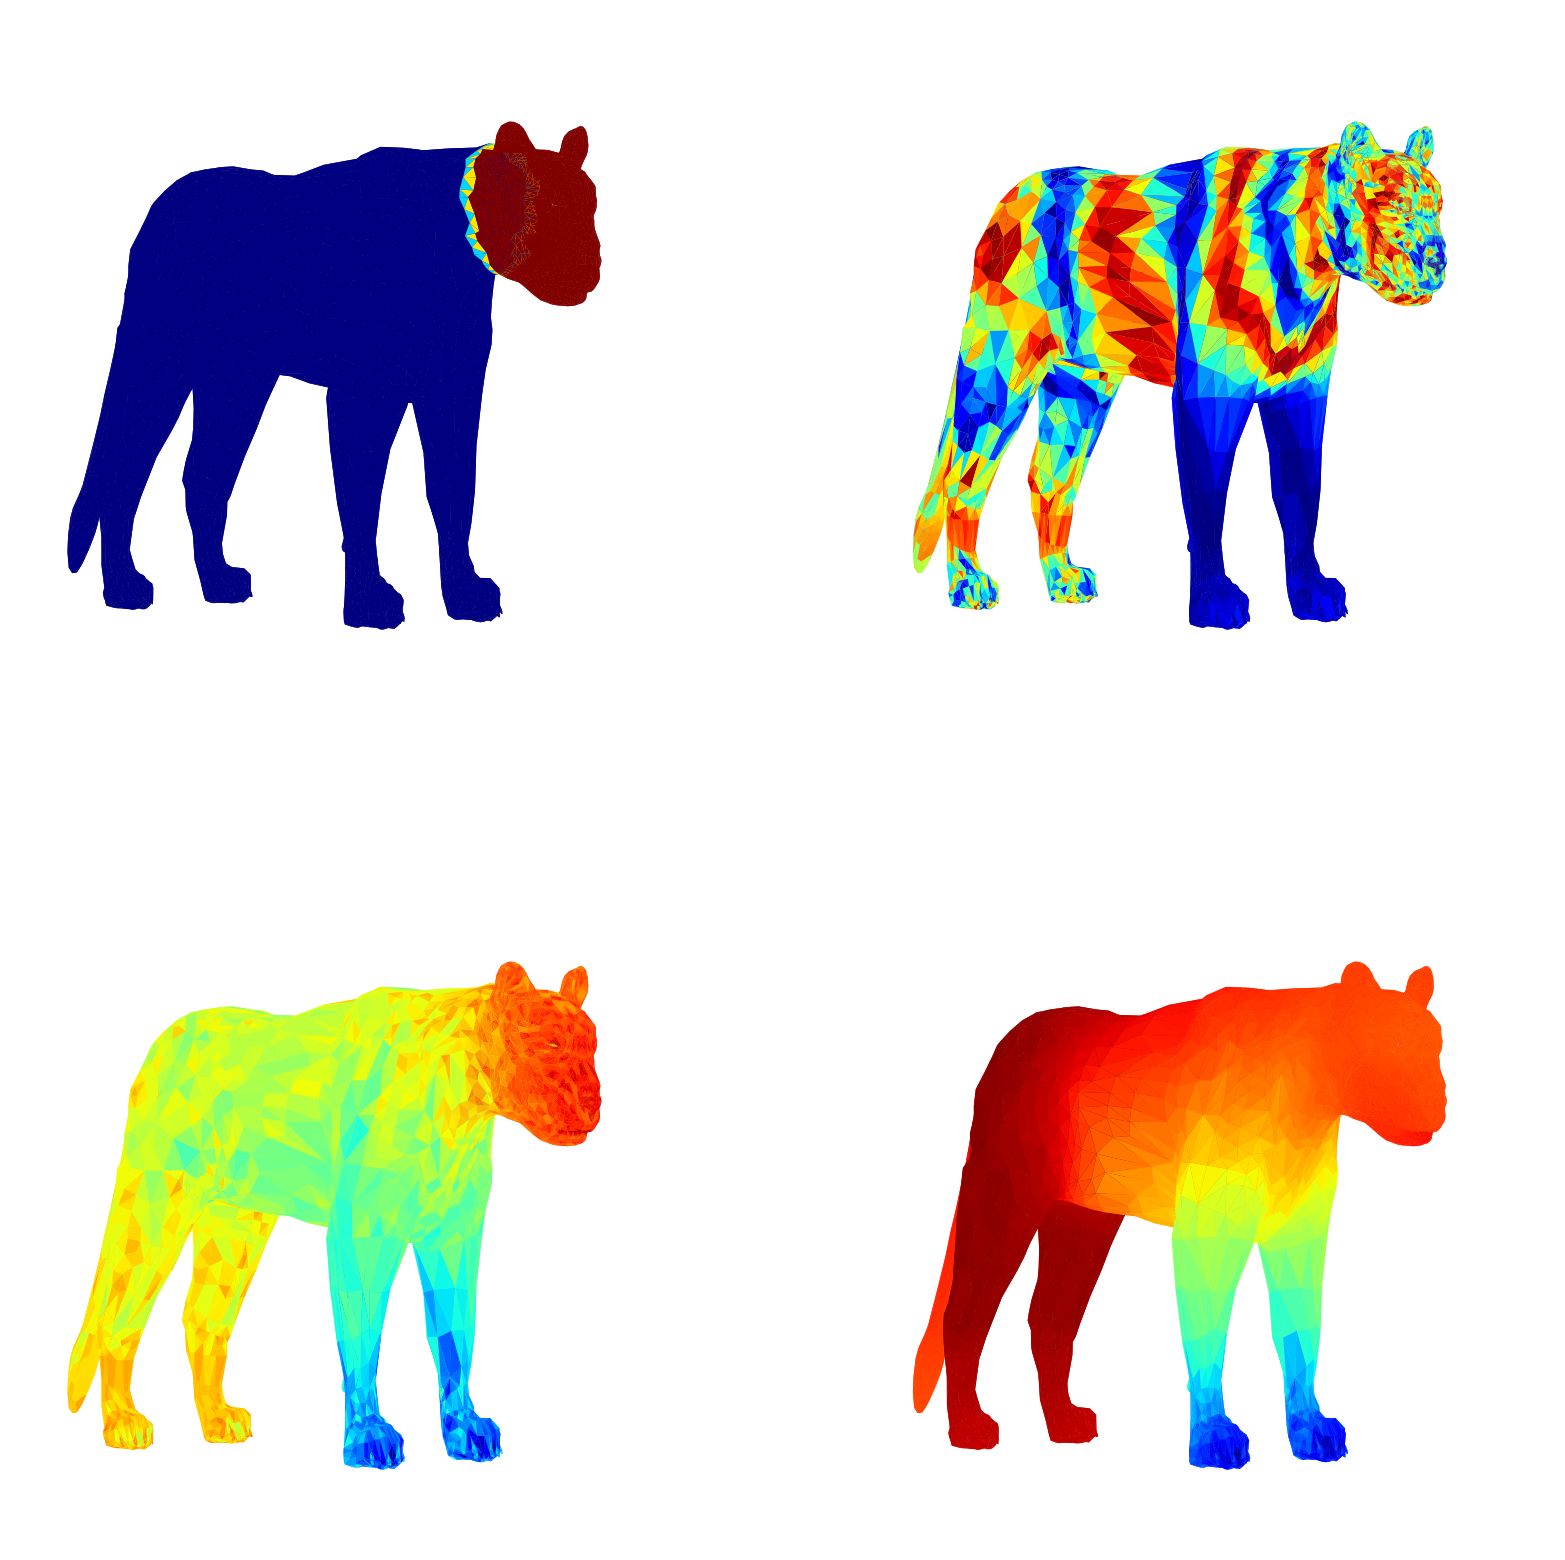

In [232]:
slepian_filterexample(vertices, faces_index, toplots)

#### Paper: Figure 3

In [ ]:
NW = 9
basis, basis_eig0, basis_conc, basis_cut = compute_slepians(norm_L, head_indexes, NW, 1, maxiter=2500)

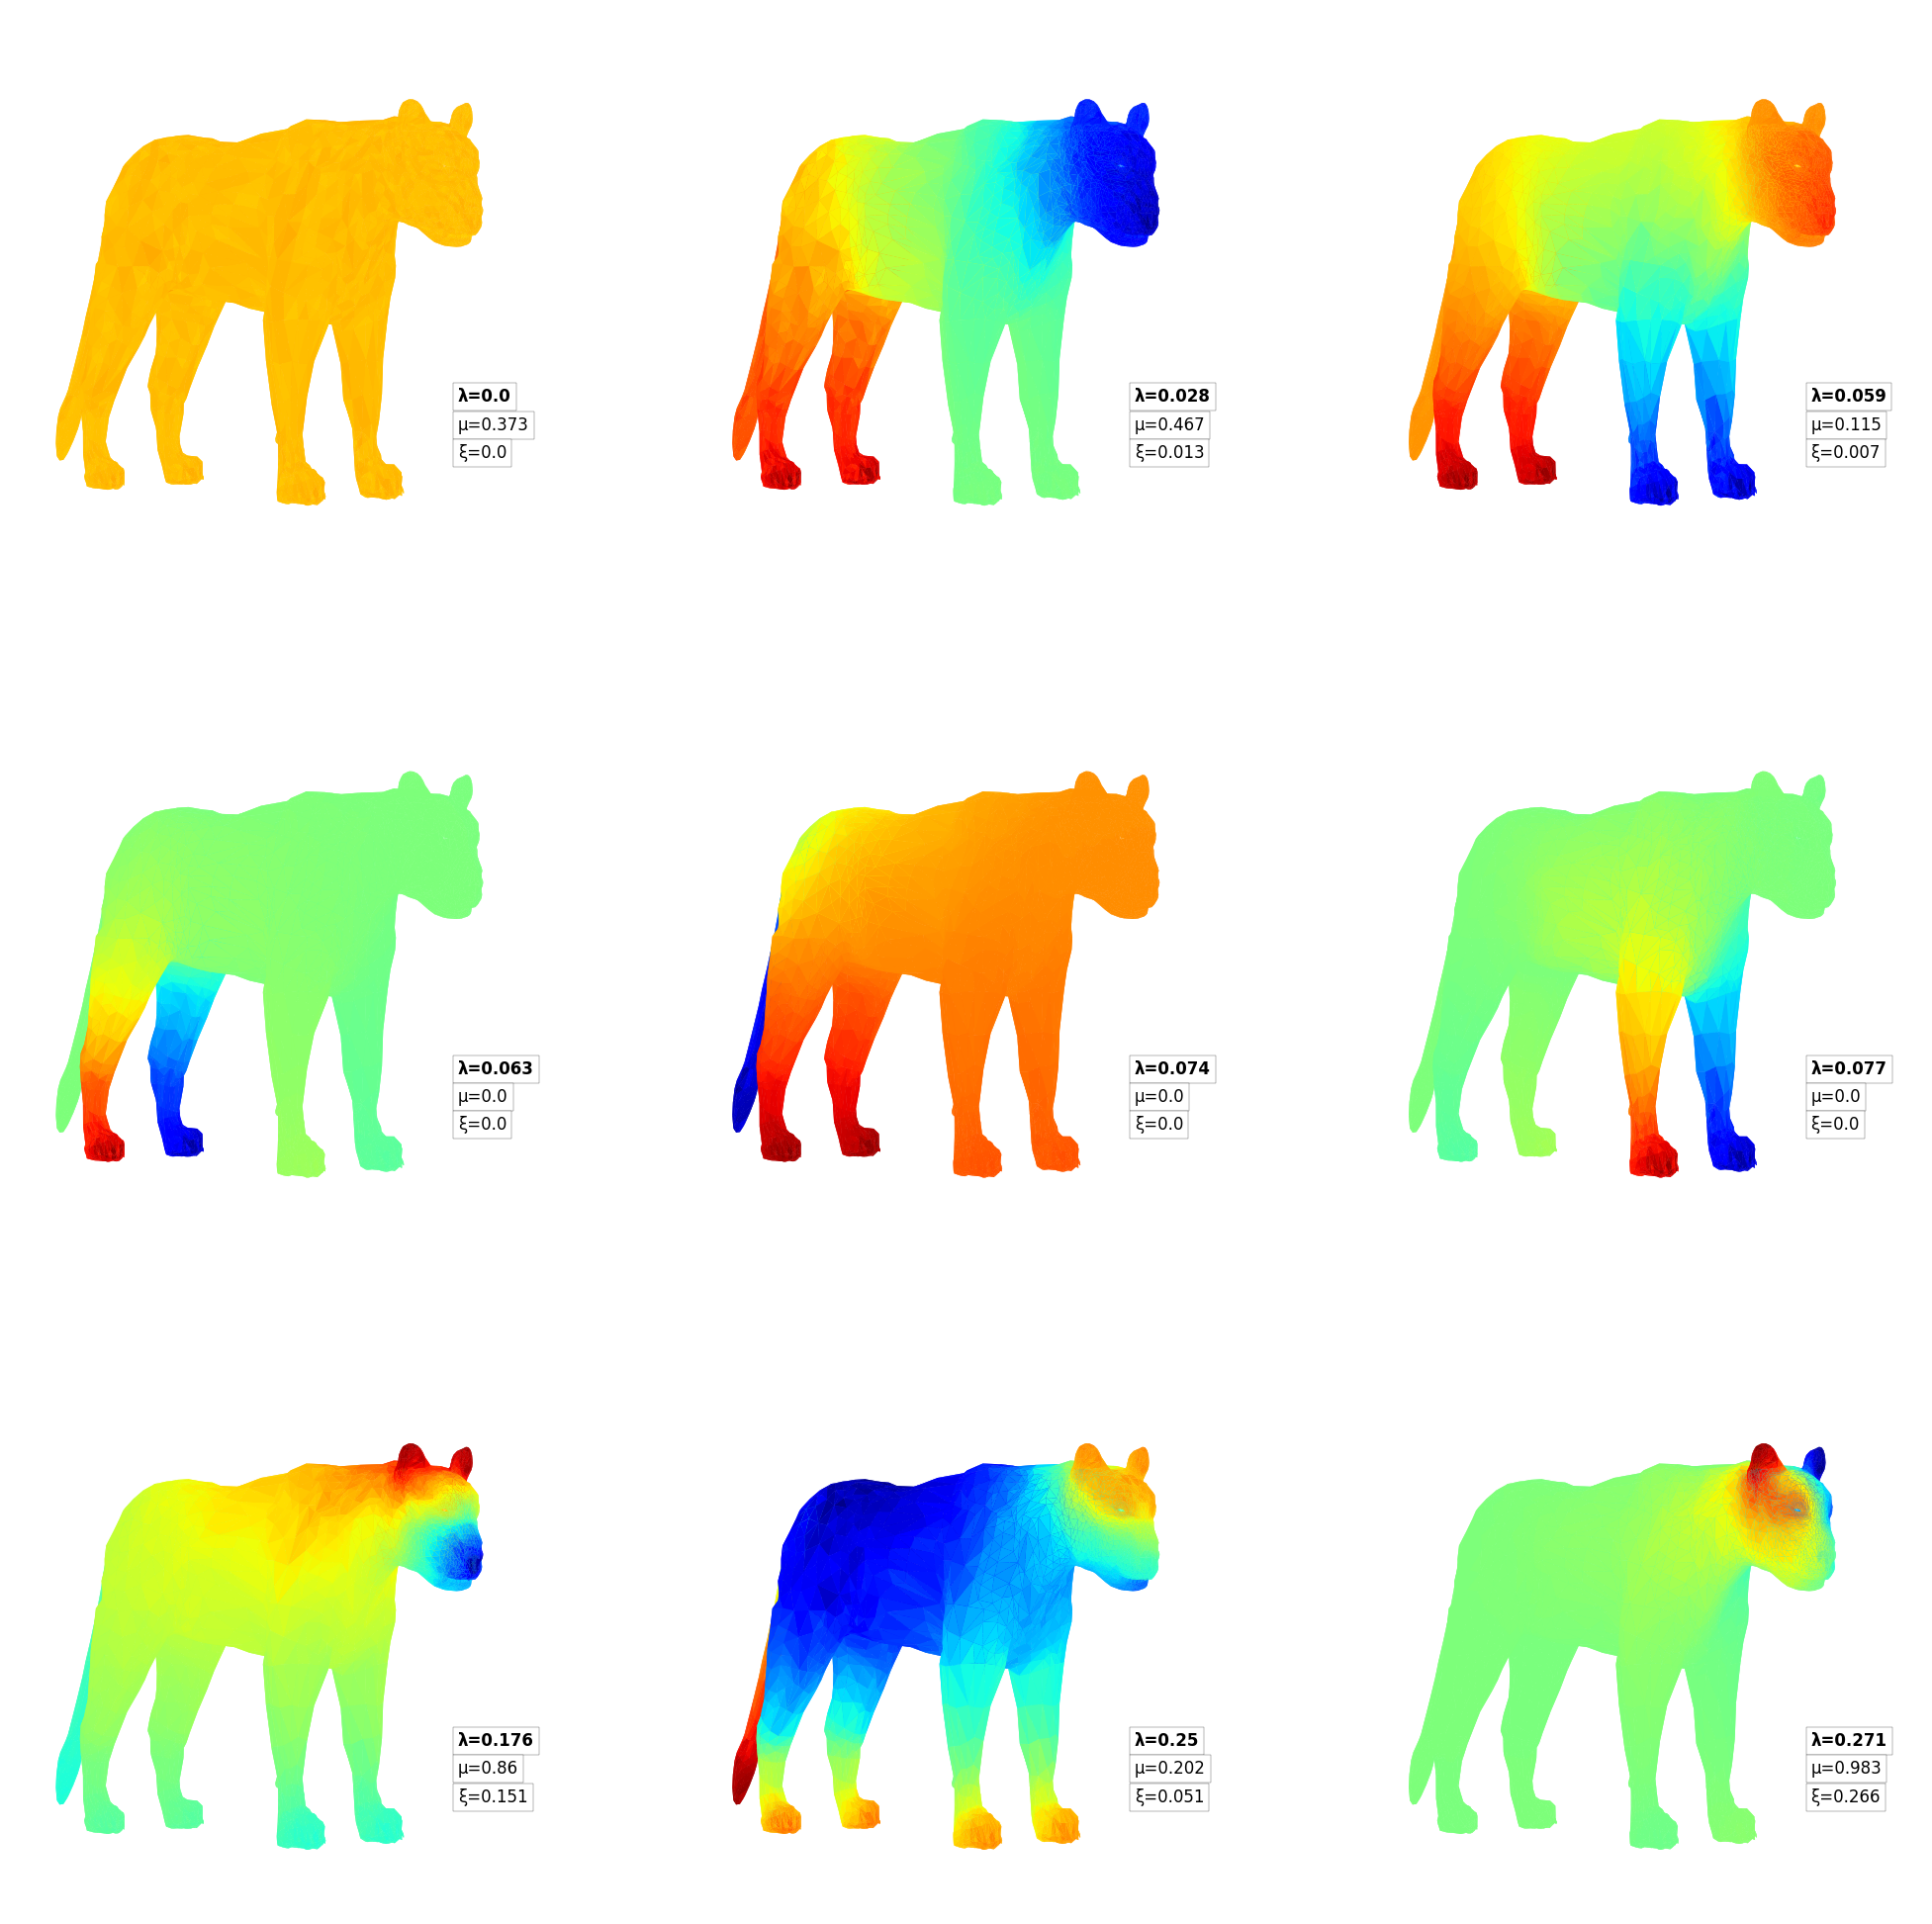

In [41]:
lbda = np.round(basis_eig0[0],3)
conc = np.round(basis_conc[0],3)
cut = np.round(basis_cut[0],3)

lowfreq_9mesh(vertices, faces_index, basis[0], [lbda, conc, cut], figsize=(25,25), bold=0)

#### Paper: Figure 4

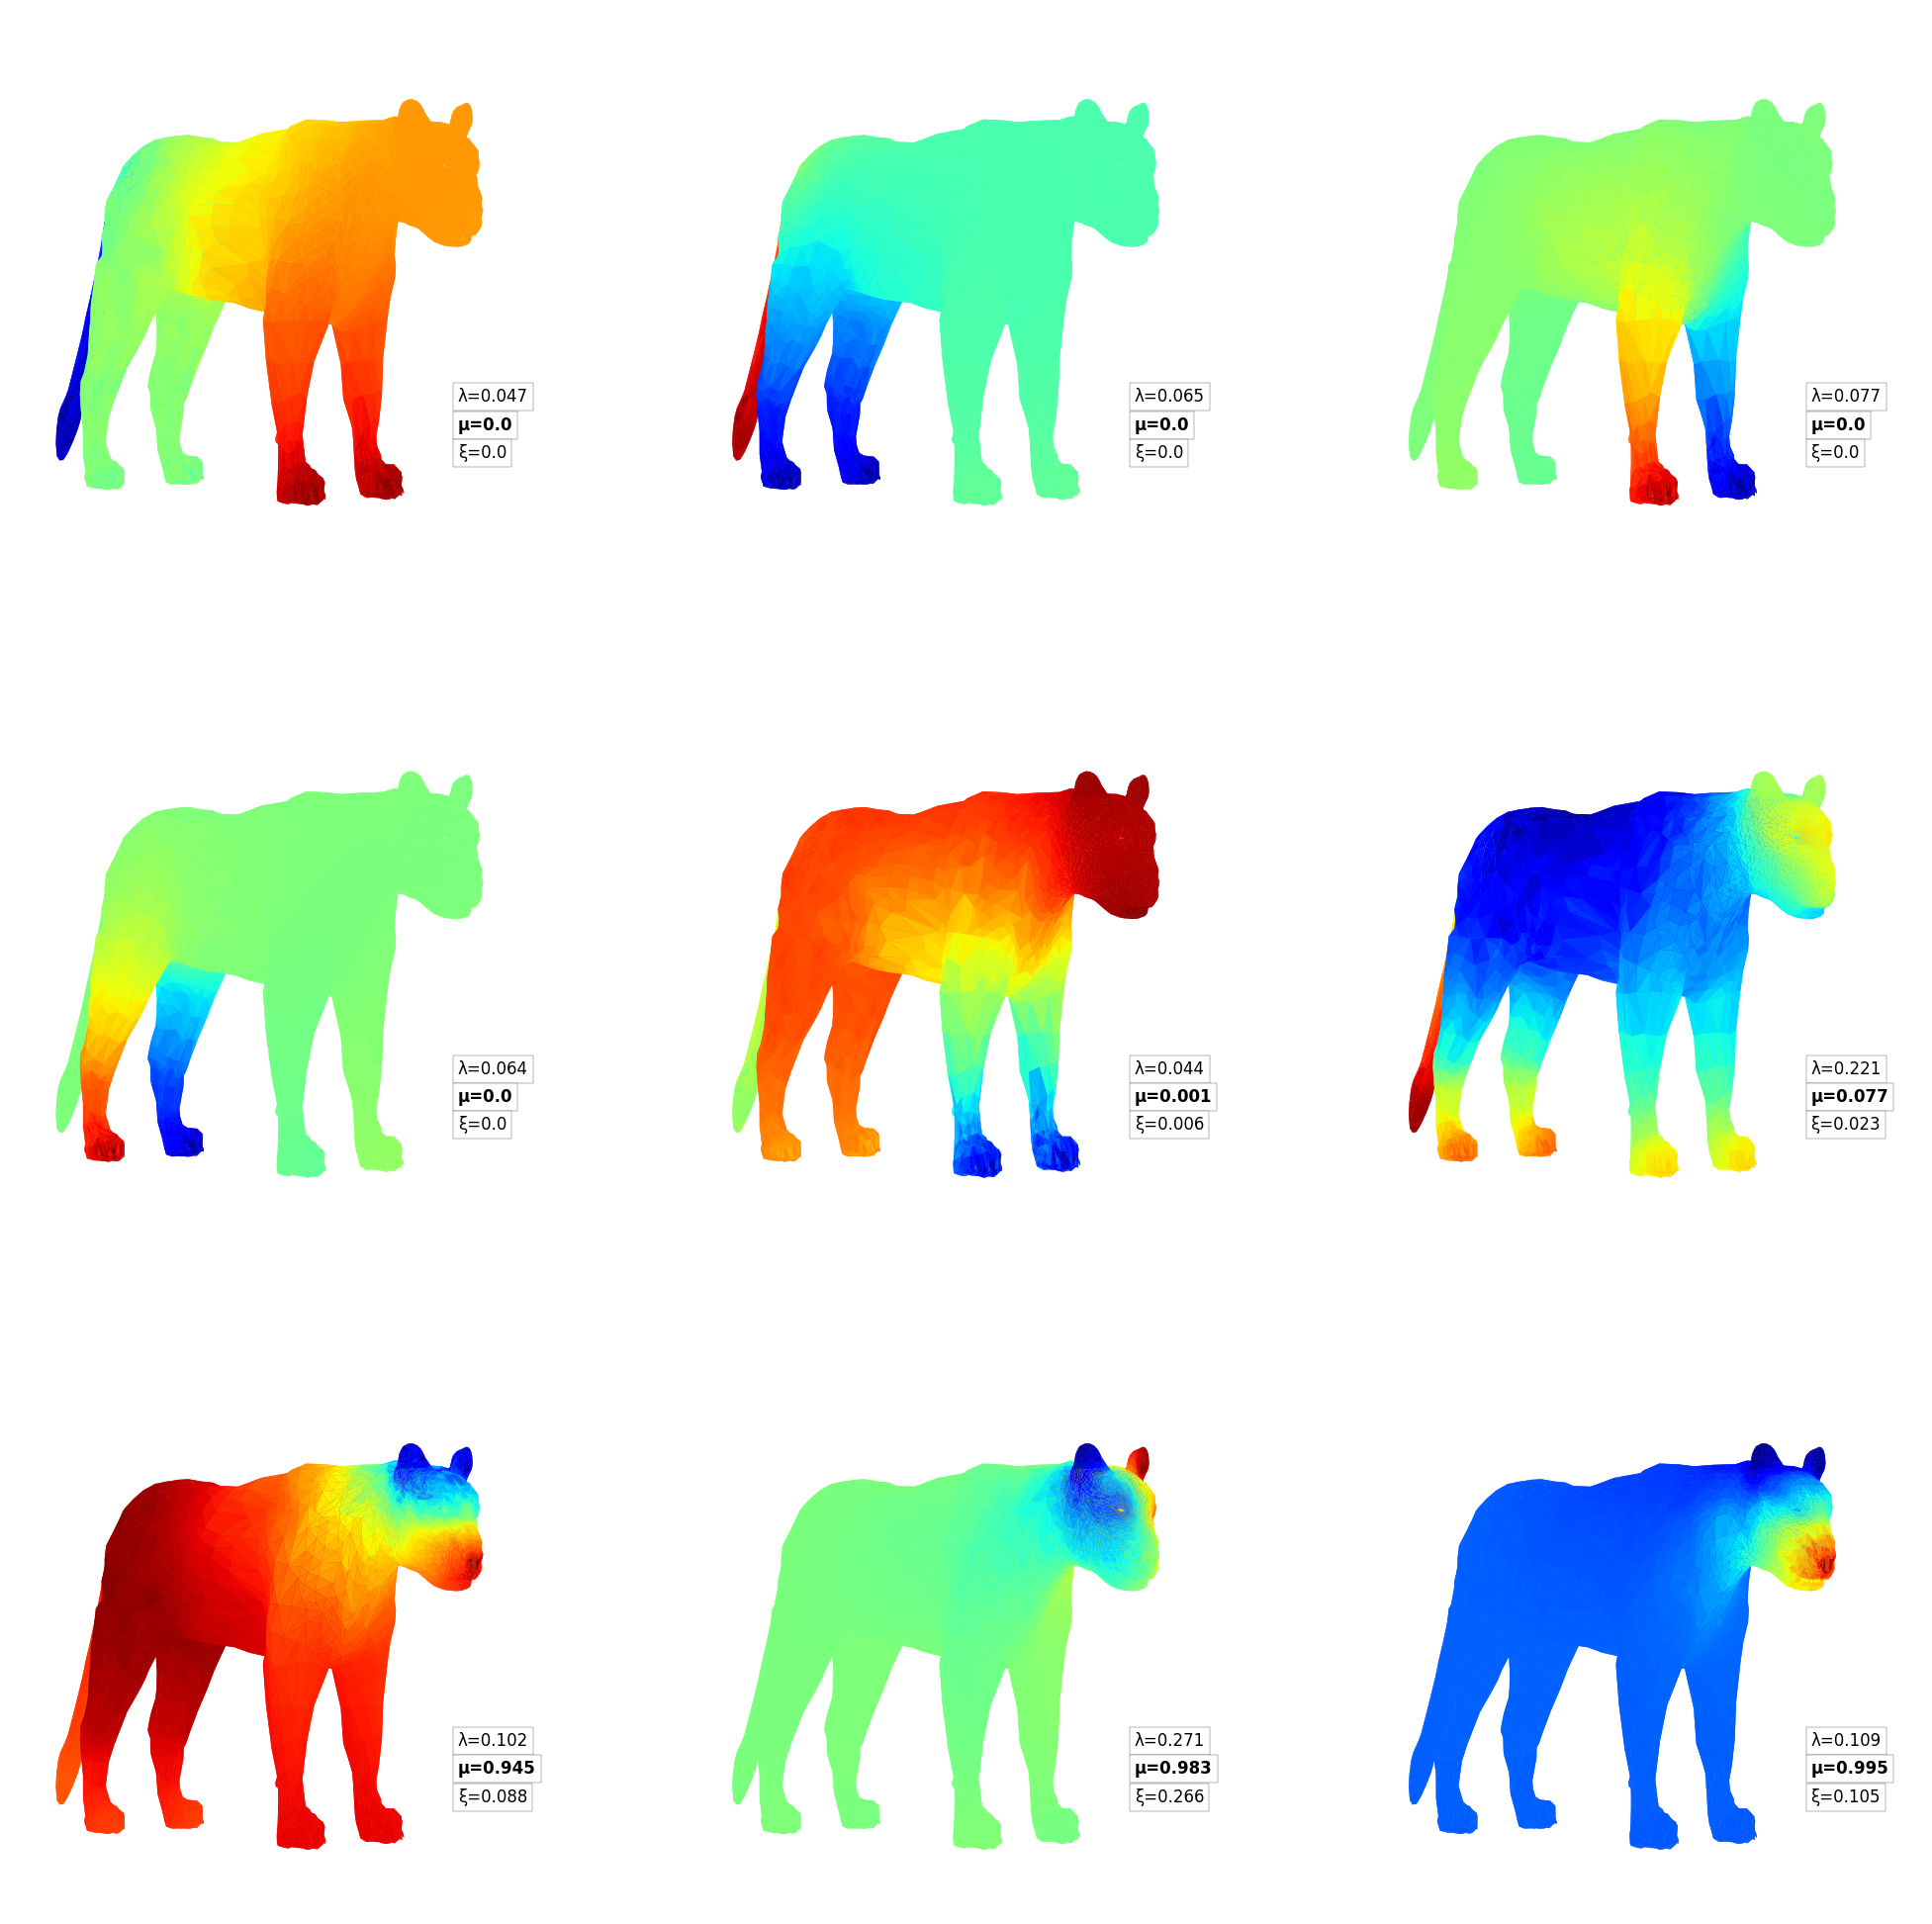

In [42]:
lbda = np.round(basis_eig0[1],3)
conc = np.round(basis_conc[1],3)
cut = np.round(basis_cut[1],3)

lowfreq_9mesh(vertices, faces_index, basis[1][:,np.argsort(conc)],
              [lbda[np.argsort(conc)], conc[np.argsort(conc)], cut[np.argsort(conc)]], figsize=(25,25), bold=1)

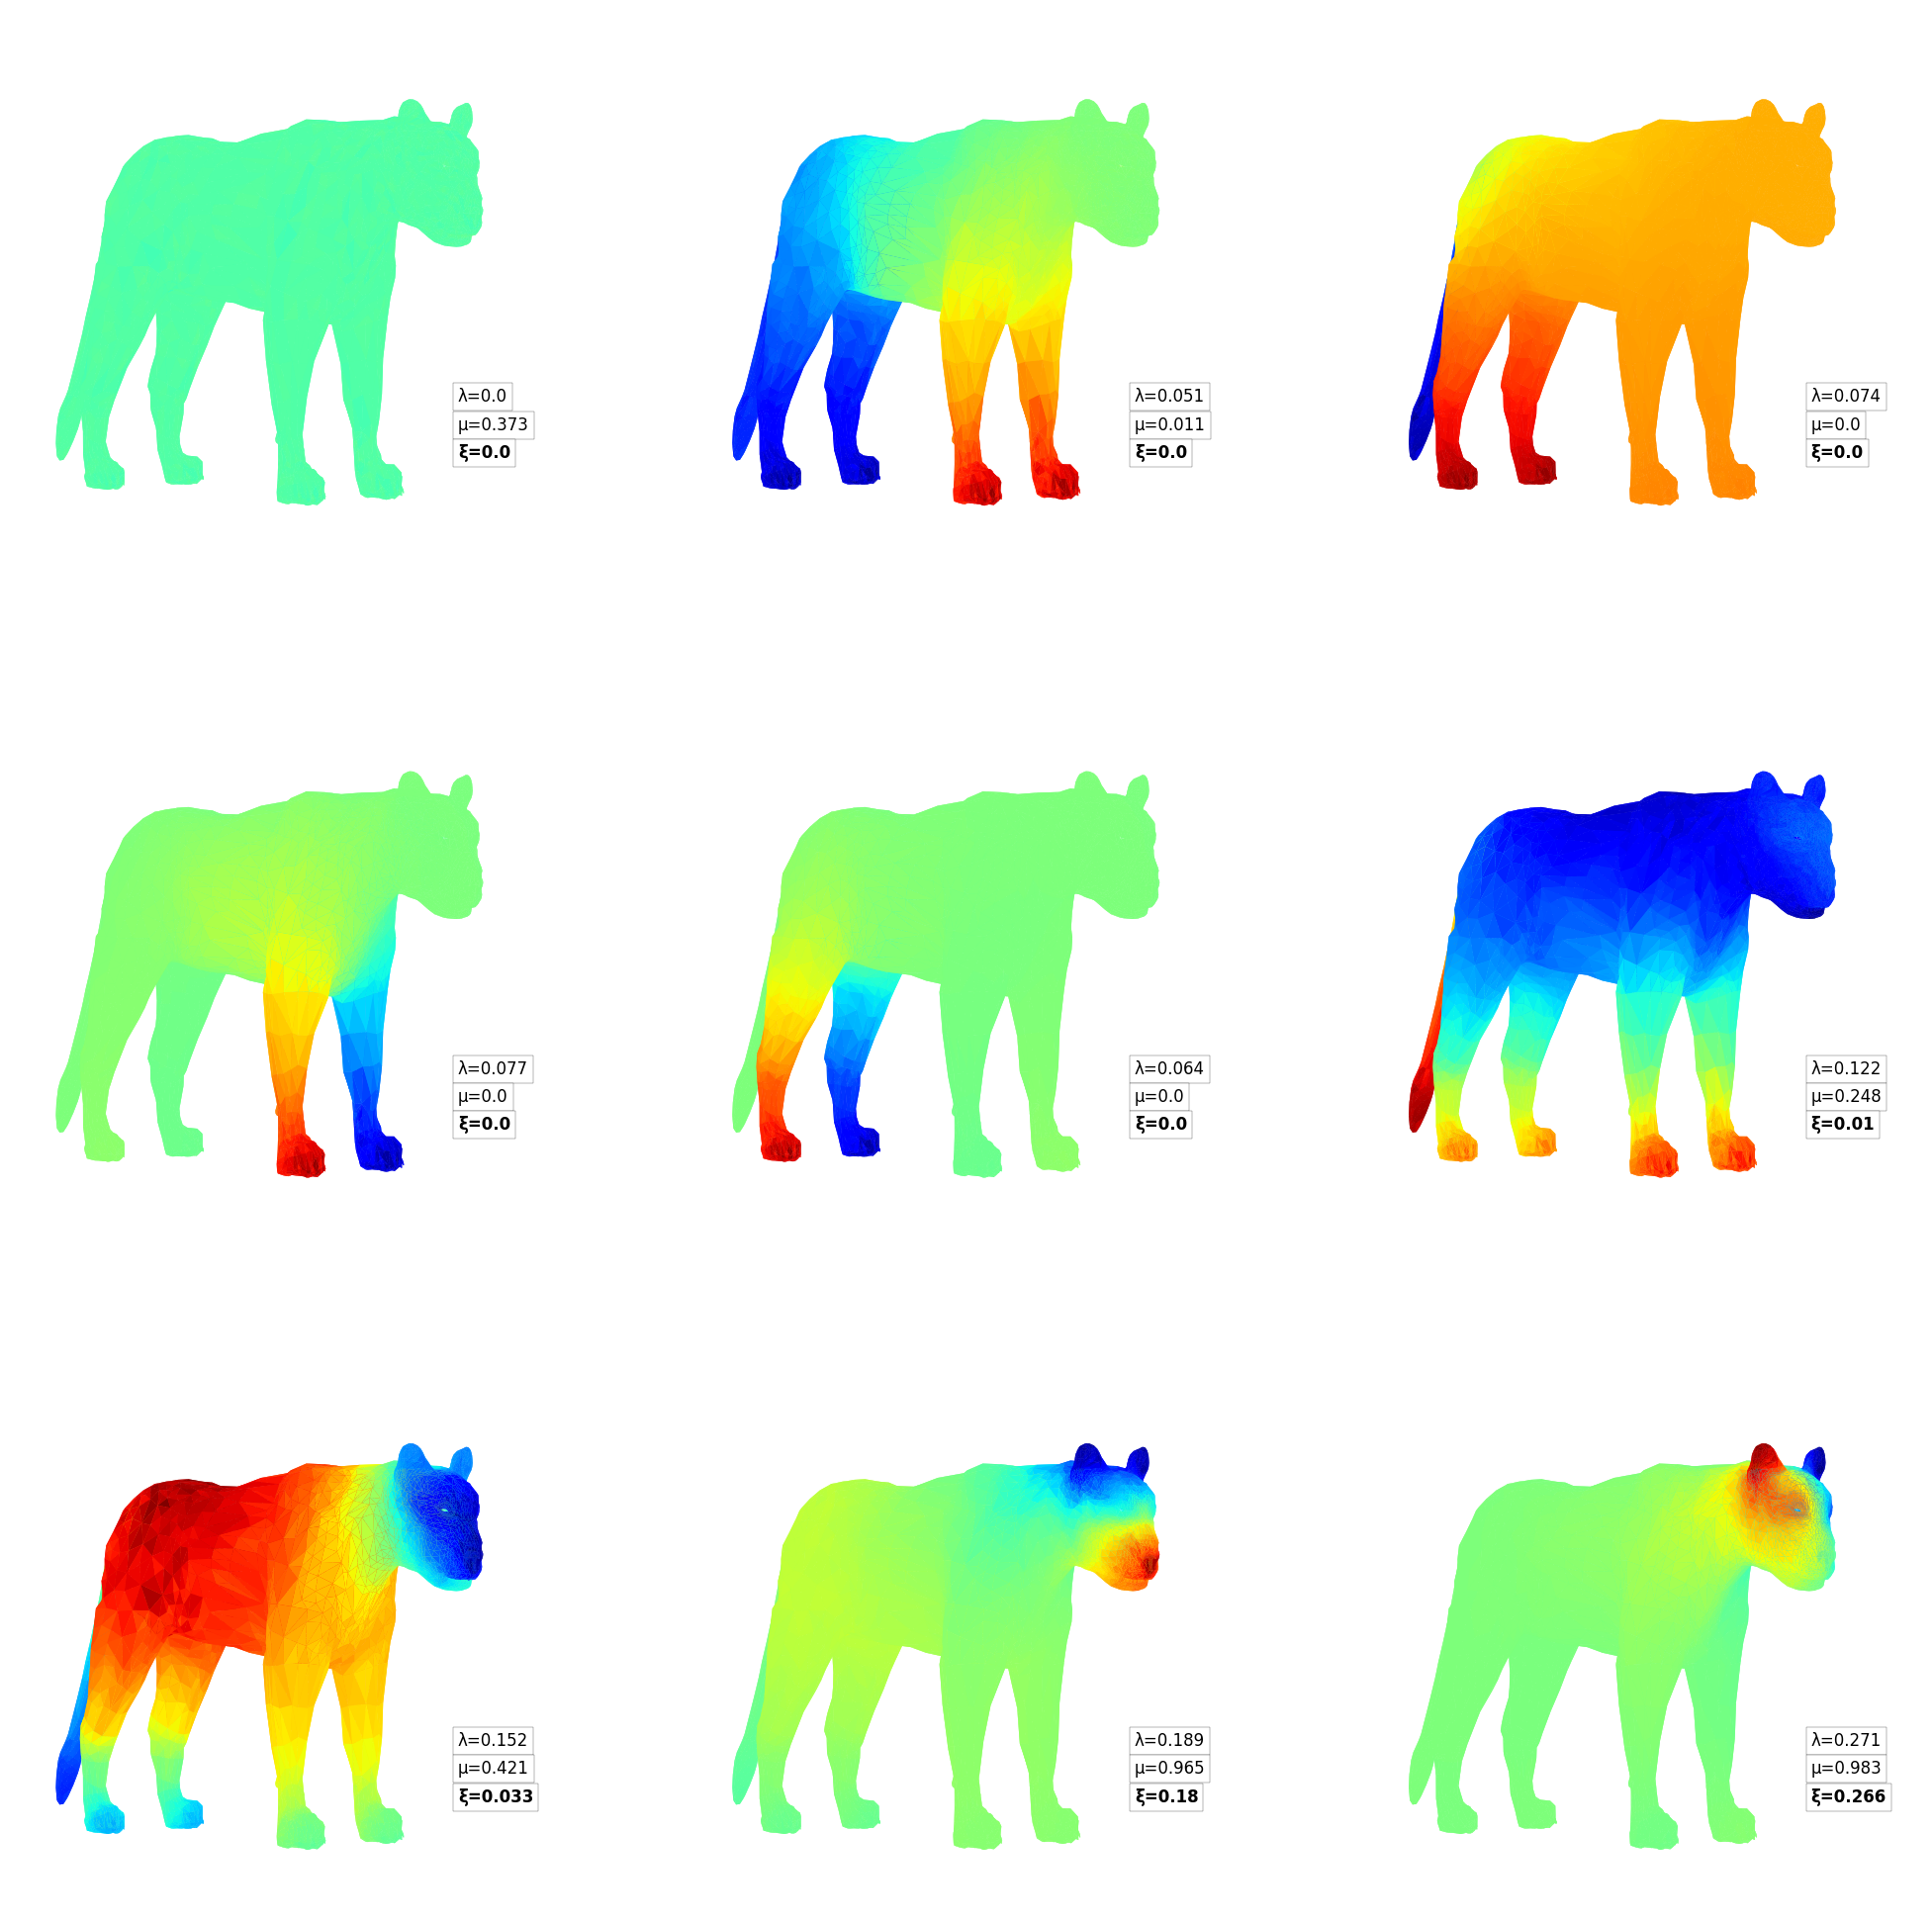

In [43]:
lbda = np.round(basis_eig0[2],3)
conc = np.round(basis_conc[2],3)
cut = np.round(basis_cut[2],3)

lowfreq_9mesh(vertices, faces_index, basis[2][:,np.argsort(cut)], 
              [lbda[np.argsort(cut)], conc[np.argsort(cut)], cut[np.argsort(cut)]], figsize=(25,25), bold=2)

### Bandlimit NW=1000

In [233]:
# compute slepians
NW = 1000
basis, basis_eig0, basis_conc, basis_cut = compute_slepians(norm_L, head_indexes, NW, 1, maxiter=2500)

#### Paper: Figure 5

Text(0, 0.5, 'ξ (modified embedded distance)')

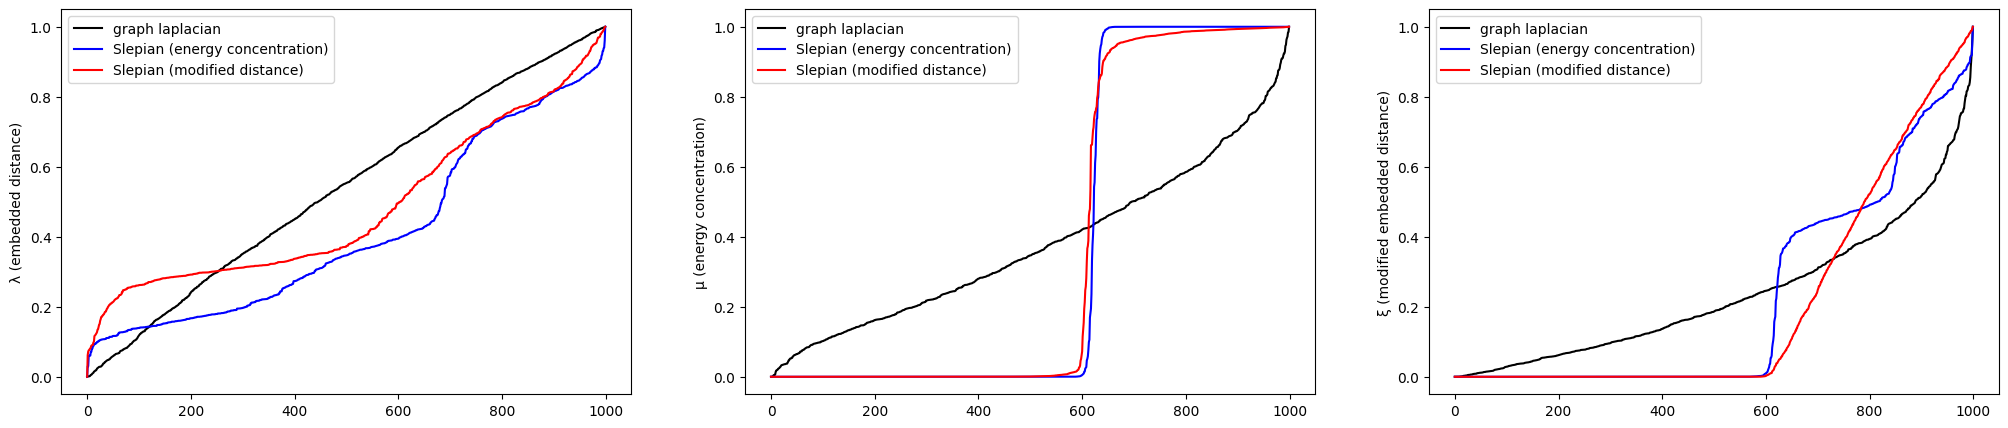

In [243]:
# eigenvalue, concentration, cut
fig, ax = plt.subplots(1,3,figsize=(25,5))
score = [basis_eig0, basis_conc, basis_cut]
colors = ['k', 'b', 'r']
for k in range(3):
    label = ["graph laplacian", "Slepian (energy concentration)", "Slepian (modified distance)"]
    ax[0].plot(np.sort(z_score(score[0][k])), label=label[k], c=colors[k])
    ax[1].plot(np.sort(z_score(score[1][k])), label=label[k], c=colors[k])
    ax[2].plot(np.sort(z_score(score[2][k])), label=label[k], c=colors[k])

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel("λ (embedded distance)")
ax[1].set_ylabel("μ (energy concentration)")
ax[2].set_ylabel("ξ (modified embedded distance)")